# Mixed Targets

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.layers

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score, precision_score, recall_score, classification_report

from sklearn.datasets import make_regression, make_classification

import matplotlib.pyplot as plt

In [2]:
def get_model(input_dim):

    input_layer = keras.Input(shape=(input_dim,), name="input_layer")

    dense_1 = keras.layers.Dense(input_dim, name = 'dense_1')(input_layer)
    dense_2 = keras.layers.Dense(input_dim, name = 'dense_2')(dense_1)

    regression_output = keras.layers.Dense(1, activation = 'linear', name = 'regression_output')(dense_2)
    classification_output = keras.layers.Dense(1, activation = 'sigmoid', name = 'classification_output')(dense_2)

    model = keras.Model(inputs=input_layer,outputs=[regression_output, classification_output])
    
    return(model)

def get_predictions(model, df):
    
    predictions = model.predict(df)

    pdf = pd.DataFrame(predictions[1], columns = ['predicted_proba'])

    pdf['predicted_class'] = pdf.predicted_proba >= 0.5

    pdf['actual_class'] = y_test.class_target.reset_index(drop=True)

    pdf['predicted_quality'] = predictions[0]

    pdf['actual_quality'] = y_test.reg_target.reset_index(drop=True)
    
    return(pdf)

def evaluate_model(df):
    
    precision = precision_score(df.actual_class, df.predicted_class)
    recall = recall_score(df.actual_class, df.predicted_class)
    r2 = r2_score(df.actual_quality, df.predicted_quality)
    
    return(r2, precision, recall)

In [3]:
X_reg, y_cont = make_regression(n_samples = 1000, n_features = 10, n_informative = 5, noise = 25)

X_class, y_class = make_classification(n_samples = 1000, n_features = 10, n_informative = 2)

df = pd.concat([pd.DataFrame(X_reg), pd.DataFrame(X_class)], axis=1)

y = pd.concat([pd.DataFrame(y_cont), pd.DataFrame(y_class)], axis=1)

y.columns = ['reg_target','class_target']

X_train, X_test, y_train, y_test = train_test_split(df, y, stratify = y.class_target)

In [31]:
result_dict = {}

for loss_weight_param in ([1,100],[1,50],[1,10],[1,1],[10,1],[50,1],[100,1]):
    
    model = get_model(20)
    
    model.compile(
    optimizer="adam",
    loss=[
        keras.losses.MeanSquaredError(),
        keras.losses.BinaryCrossentropy(),
    ],loss_weights = loss_weight_param)
    
    model.fit(X_train,
    {"regression_output": y_train.reg_target, "classification_output": y_train.class_target},
    epochs=30,
    batch_size=50,
          verbose=0)
    
    predictions = get_predictions(model, X_test)
    
    result_dict.update({str(loss_weight_param):evaluate_model(predictions)})

In [29]:
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           420         input_layer[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           420         dense_1[0][0]                    
__________________________________________________________________________________________________
regression_output (Dense)       (None, 1)            21          dense_2[0][0]                    
______________________________________________________________________________________

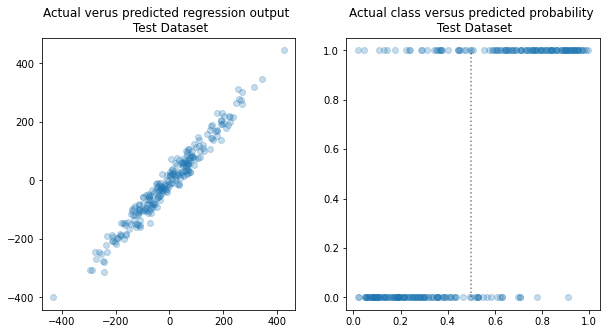

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(predictions.predicted_quality, predictions.actual_quality, alpha = 0.25)
plt.title('Actual verus predicted regression output \n Test Dataset')
plt.subplot(1,2,2)
plt.scatter(predictions.predicted_proba, predictions.actual_class, alpha = 0.25)
plt.title('Actual class versus predicted probability \n Test Dataset')
plt.vlines(x = 0.5, ymin=0, ymax=1, color ='k', linestyle = ':', alpha = 0.5)
plt.show()

In [1485]:
r2_list = list()
prec_list = list()
rec_list = list()

for i in result_dict.values():
    r2_list.append(i[0])
    prec_list.append(i[1])
    rec_list.append(i[2])

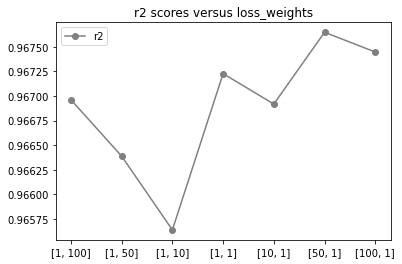

In [1487]:
plt.plot(result_dict.keys(),r2_list, marker = 'o', label = 'r2', color ='grey')
plt.title('r2 scores versus loss_weights')
plt.legend()

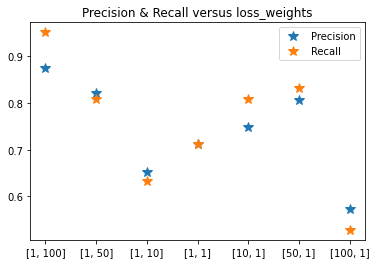

In [1488]:
fig, ax = plt.subplots()

ax.plot(result_dict.keys(), prec_list, marker = '*', markersize = 10, linestyle = '', label = 'Precision')
ax.plot(rec_list, marker ='*', markersize = 10, linestyle = '', label = 'Recall')
plt.title('Precision & Recall versus loss_weights')
plt.legend()
plt.show()

In [1489]:
result_dict

{'[1, 100]': (0.9669623175831203, 0.875, 0.952),
 '[1, 50]': (0.9663894166744459, 0.8211382113821138, 0.808),
 '[1, 10]': (0.9656396957653813, 0.6528925619834711, 0.632),
 '[1, 1]': (0.9672275110539601, 0.712, 0.712),
 '[10, 1]': (0.966918385733183, 0.7481481481481481, 0.808),
 '[50, 1]': (0.9676479568280973, 0.8062015503875969, 0.832),
 '[100, 1]': (0.9674468549971792, 0.5739130434782609, 0.528)}

# End